In [1]:
import mlflow
import requests
import skimage.io
from matplotlib import pyplot as plt

# Part 0: Set up

Before we proceed we need to setup and launch a few things.

## DVC
We assume that the data version control is set up and we'll pull the data from the remote

In [3]:
! git checkout master
! dvc pull
! git checkout -b demonstration

M	demonstration.ipynb
Already on 'master'
Your branch is up to date with 'origin/master'.
Fetching
!
  0% Checking cache in '/home/dlowl/git/bunny-party/.dvc/cache/files/md5'| |0/? 
                                                                                
!
  0% Querying remote cache|                          |0/2 [00:00<?,    ?files/s]
 50% Querying remote cache|██████████▌          |1/2 [00:00<00:00,  2.95files/s]
                                                                                
!
  0% Querying remote cache|                          |0/0 [00:00<?,    ?files/s]
                                                                                
!
  0% Checking cache in 'dvc/files/md5'|              |0/? [00:00<?,    ?files/s]
md5: f75704db88c160f8949a91c734150d16
Fetching
Building workspace index                              |330 [00:00, 6.48kentry/s]
Comparing indexes                                     |329 [00:00, 14.7kentry/s]
Applying changes                    

## MLFlow
MLFlow is used for experiment tracking. We just use local server for tracking, but in a real world scenario I would connect to a remote one, shared by the team. Run the command below in your shell to start the server
```
mlflow server
```

## Model training server
The server has been written for this exersice, that will perform model training, evaluation as well as data relabeling procedures. Assuming the environment is already set up, run this command in your shell to start it.
```
python bunny_server/server.py
```

## Part 1: Train and evaluate the initial model
We first call the server to train a model using the initial dataset.

In [4]:
requests.post("http://localhost:8000/train_model")

<Response [200]>

Let's check what dataset versions were tracked by MLFlow for this model training run.

In [5]:
last_run = mlflow.search_runs().iloc[0]
print("Train dataset: ", last_run["params.train_git_revisions"], last_run["params.train_committed_datetime"])
print("Test dataset: ", last_run["params.test_git_revisions"], last_run["params.test_committed_datetime"])

Train dataset:  ['f65dde43221198ad4c53300fe84a15a73002921d', 'tags/data/v1~3'] 2023-09-28 21:19:01+04:00
Test dataset:  ['f65dde43221198ad4c53300fe84a15a73002921d', 'tags/data/v1~3'] 2023-09-28 21:19:01+04:00


The server has successfully finished training a model; the model artifact is now available on the filesystem at `models/classifier.keras` as well as in the MLFlow registry.

You can visit [the MLFlow experiment dashboard](http://127.0.0.1:5000/#/experiments) to view the experiment results (i.e training, validation and testing performance, artifacts, etc.). Alternatively, we can query the model training server directly to do model evaluation.

In [6]:
response = requests.get("http://localhost:8000/evaluate_model")
display(response)
response.json()

<Response [200]>

{'test_loss': 0.9904901385307312, 'test_accuracy': 0.8500000238418579}

Test accuracy of ~85%, the model is not too great at identifying threats.

# Part 2: Relabeling

We were hinted at that some the images marked as enemies (class ID 0), are indeed not enemies. For example, we can see an impostor dog's picture under `data/train/0/1b2c58d79150a6b863b2c8e8619c98ca.jpg`

![](data/train/0/1b2c58d79150a6b863b2c8e8619c98ca.jpg)

We want to identify more of these and relabel them to Class ID 1. Looking through the whole training set would require time. But we can simplify our job by performing similarity search

The process is still requires manual intervention (to confirm that the found images are indeed impostor's). The process is iterative, some cells need to be run multiple times:
1. Run the `Setup Relabeling` cell ones
2. Run the `Take Next Seed` cell ones
3. Run the `Query Similar Images` cell, and check that the images are indeed Arnie
4. Modify `MARKED_TO_RELABEL` list according to which images you want to relabel, and run the `Relabel Request` cell
5. Repeat from 2, until done.

PUBLIC NOTE: This process is a bit clunky in the notebook, and I would probably do it in some simple web UI or CLI tool in the real world.


In [7]:
# Setup Relabeling
seed_image_id = "1b2c58d79150a6b863b2c8e8619c98ca"
images_relabeled = 0
search_iterations = 0
seed_image_queue = [seed_image_id]

In [84]:
# Take Next Seed
if len(seed_image_queue) > 0:
    seed_image_id = seed_image_queue.pop(0)
    display(seed_image_id)
else:
    display("No seed images left.")

'No seed images left.'

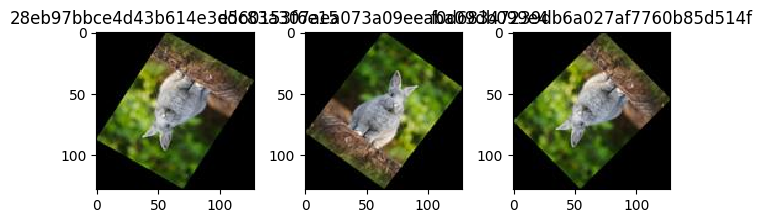

In [85]:
# Query Similar Images
response = requests.get(f"http://localhost:8000/similar_images?img_id={seed_image_id}&class_id=0&n=3")
similar_images = response.json()
for i, image in enumerate(similar_images):
    plt.subplot(1, 3, i+1)
    skimage.io.imshow(f"data/train/0/{image['id']}.jpg")
    plt.title(image["id"])
plt.show()
search_iterations += 1

In [65]:
# Relabel Request
# IMPORTANT: modify MARKED_TO_RELABEL according to what you see above before running
MARKED_TO_RELABEL = [
    False,
    True,
    True
]

for i in range(3):
    if MARKED_TO_RELABEL[i]:
        image = similar_images[i]
        display(f"Relabel {image['id']} to Class ID 1")
        display(requests.post("http://localhost:8000/relabel", json={"img_id": image['id'], "class_id": 1}))
        seed_image_queue += [image["id"]]
        images_relabeled += 1

'Relabel 5a4f119456a1922076b0fe1e6ecf18ab to Class ID 1'

<Response [200]>

'Relabel d781c4147a82e25be800c7d147535a6b to Class ID 1'

<Response [200]>

In [86]:
print("Total search iterations", search_iterations)
print("Total images relabeled", images_relabeled)

Total search iterations 32
Total images relabeled 30


Now that the Arnies are relabeled, we can version the resulting training dataset

In [87]:
! dvc add data/train
! git add data/train.dvc
! git commit -m "Version training dataset after relabeling the impostor dog"
! git tag data-v2-clean

ore>⠋ Checking graph
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/home/dlowl/git/bunny-party/.dvc/cache/files/md5'| |0/? 
                                                                                
!
  0%|          |Checking out /home/dlowl/git/bunny-par0/? [00:00<?,    ?files/s]
  0%|          |Checking out /home/dlowl/git/bunny-p0/241 [00:00<?,    ?files/s]
 28%|██▊       |Checking out /home/dlowl/git/67/241 [00:00<00:00, 663.16files/s]
 65%|██████▌   |Checking out /home/dlowl/git157/241 [00:00<00:00, 800.03files/s]
 99%|█████████▉|Checking out /home/dlowl/git238/241 [00:00<00:00, 701.62files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00,  1.68file/s]

To track the changes with git, run:

	git add data/train.dvc

To enable auto staging, run:

	dvc config core.autostage true
[demonstration 710db4c] Version traini

# Part 3: Did we do better?

Now let's retrain the model and see if the performance is any better.

In [88]:
display(requests.post("http://localhost:8000/train_model"))

<Response [200]>

Let's confirm that the model training run has indeed used the updated versions of the data (only the training dataset should show an update in this case)

In [89]:
last_run = mlflow.search_runs().iloc[0]
print("Train dataset: ", last_run["params.train_git_revisions"], last_run["params.train_committed_datetime"])
print("Test dataset: ", last_run["params.test_git_revisions"], last_run["params.test_committed_datetime"])

Train dataset:  ['710db4c23eef6d0ebe48335c0416d1710e6c045f', 'tags/data-v2-clean'] 2023-09-28 22:04:55+04:00
Test dataset:  ['f65dde43221198ad4c53300fe84a15a73002921d', 'tags/data/v1~3'] 2023-09-28 21:19:01+04:00


In [90]:
response = requests.get("http://localhost:8000/evaluate_model")
display(response)
response.json()

<Response [200]>

{'test_loss': 0.0003378996334504336, 'test_accuracy': 1.0}

The performance has improved greatly.